# We will be creating a Siamese Network in keras on the Omniglot dataset as part of the Fellowship.ai challenge

In [1]:
###Loading the libraries###
###I have used the https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
### to help me with this challenge
import time
import numpy as np
import pandas as pd
from skimage import io
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, merge
from keras.models import Model
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense
import numpy.random as rng

from sklearn.utils import shuffle

Using TensorFlow backend.


# A function to load the data

In [2]:
##Loading a Images into variable. The images are letters from each different alphabets and they are stored in a numpy array.
## My computer was taking too long to load the entire training dataset(characters) so I loaded a subset of the characters
##Input: Path of the file
##Output: A numpy Stacked 3d array of images for each alphabet and their respective letters
def loadFile(path):
    character_path = {}
    n = 0
    X = []
    y = []
    for alphabet in os.listdir(path):
        print (alphabet)
        for character in os.listdir(path+'/'+alphabet):

            character_images= []
            character_path[n] = (alphabet,character)
            for image in os.listdir(path+'/'+alphabet+'/'+character):

                image_read = io.imread(path+'/'+alphabet+'/'+character+'/'+image)

                character_images.append(image_read)
                y.append(n)

                
            n= n+1;

            X.append(np.stack(character_images))

    X = np.stack(X)
    return X, np.vstack(y)

In [3]:
print ("Loading Training Set") 
print("\n---------------------\n")

X,y=loadFile("D:\\Users\\npjos\\Documents\\Code\\Python\\images_background\\images_background")

print("\n---------------------\n")
print ("Loading Evaluation set")
print("\n---------------------\n")

Xval,yval = loadFile("D:\\Users\\npjos\\Documents\\Code\\Python\\images_evaluation\\images_evaluation")

Loading Training Set

---------------------

Alphabet_of_the_Magi
Anglo-Saxon_Futhorc
Arcadian
Armenian
Asomtavruli_(Georgian)
Balinese
Bengali
Blackfoot_(Canadian_Aboriginal_Syllabics)
Braille
Burmese_(Myanmar)
Cyrillic
Early_Aramaic

---------------------

Loading Evaluation set

---------------------

Angelic
Atemayar_Qelisayer
Atlantean
Aurek-Besh
Avesta
Ge_ez
Glagolitic
Gurmukhi
Kannada
Keble
Malayalam
Manipuri
Mongolian
Old_Church_Slavonic_(Cyrillic)
Oriya
Sylheti
Syriac_(Serto)
Tengwar
Tibetan
ULOG


In [4]:
#Randomly initalizing weights to the appropriate shape
def initialize_weights(shape, name=None):

    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

#setting bias to zero
def initialize_bias(shape, name=None):


    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [5]:
#Since a one shot classification was to be implemented in which only one training example for each class is used
#a Siamese network was choosen based on literature. There are other distance based algorithms(ex.nearest neighbour) that can identify 
## similarities between two images, but they seem to have higer error rates.
#A siamese Network are two Convolutional Neural Networks that are two copies of the same network. 
#Two input images are passed through the same network. 


#Creating a 5 layered convolution network
#Input: shape of the images
#Output: A model based on the shape
def simaese_model(input_shape):
    model = Sequential()
    right = Input(shape=input_shape)
    left = Input(shape=input_shape)
    ### 5 layered convolution network
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    encoded_l = model(left)
    encoded_r = model(right)
    
    def l1_distance(x): 
        return K.abs(x[0] - x[1])

    def l1_distance_shape(x): 
        print(x)
        return x[0]
    
    
    L1_layer = Lambda(l1_distance)
    
    merged_model = L1_layer([encoded_l, encoded_r])    
    
    
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(merged_model)
    
    siamese = Model(inputs=[left,right],outputs=prediction)
    
    return siamese

In [6]:
    model = simaese_model((105, 105, 1))  
    model.compile(loss="binary_crossentropy",optimizer=Adam(lr=0.00006))

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
#Creating a batch with half the pairs with same letter and other half with different letters(chosen randomly)
#Input: Size of the batch size and the image array
#Output: 1: A pair of letters with same letters and another half with different letters 
#        Also 
def create_batch(batch_size,X):
    n_languages, n_characters, w, h = X.shape
    categories = rng.choice(n_languages,size=(batch_size,),replace=False)
    
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    targets=np.zeros((batch_size,))
    first_half_batch = int (batch_size/2)
    
    for i in range(first_half_batch) :
        category = categories[i]
        idx_1 = rng.randint(0, n_characters)
        
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        
        idx_2 = rng.randint(0, n_characters)
        pairs[1][i,:,:,:] = X[category,idx_2].reshape(w, h,1)
     
    ##Second half of the batch with different letters
    for i in range(first_half_batch, batch_size): 
        category = categories[i]
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
       
        
        idx_2 = rng.randint(0, n_characters)
        cat2 = get_second_pair_index(category,n_languages)
                #cat = category +1
    pairs[1][i,:,:,:] = X[cat2,idx_2].reshape(w, h,1)
    #first half of the images have the same pairs of letters
    targets[:batch_size//2] = 1
    return pairs, targets

#ensure that 2nd pair is from different language
def get_second_pair_index(category,n_languages):
    j = 0
    cat2 = 0
    while (j < 100):
        j = j +1
        cat2 = rng.randint(1,n_languages)
                
        if  (cat2 != category):
            j = 101
        elif(j ==100):
            cat2 = category-1 if (category == n_languages) else category + 1
        
    return cat2
    

In [8]:
#Create a one shot task based on the number of clases to test
#Input the X variable and number of number of classes
def make_one_shot(X,N):
    n_classes, n_examples, w, h = X.shape
    categories = rng.choice(range(n_classes),size=(N,),replace=False)

    
    indices = rng.randint(0, n_examples,size=(N,))  
    
    true_category = categories[0]   
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    indices[0] = ex2
    
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    
    support_set = X[categories,indices,:,:]
    support_set = support_set.reshape(N, w, h,1)
    
    targets = np.zeros((N,))
    targets[0] = 1
    
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]
    return pairs,targets

#Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks
def test_oneshot(model, N, k, X, verbose = 0):
    
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_one_shot(X,N)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [35]:
evaluate_every = 50 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 250 # of training iterations
N_way = 20 # of alphabets for testing one-shot tasks
n_val = 50# of one-shot tasks to validate on
best = 0


In [36]:
'''  Training the model using the pairs of images. 
Note half of the pairs have matching letters and other half have mismatch letters '''

### The average is going to be much lower since it takes over 40 minutes to train over 500 iterations. 
###So I have chosen to evaluate 250 iterations. 
###If model was trained on the cloud I could train for longer iterations and receive a higher accuracy
t_start = time.time()
for i in range(1, n_iter+1):
        (inputs,targets) = create_batch(batch_size,X)
        loss = model.train_on_batch(inputs, targets)
        
        if i % 10 == 0:
            print ("Time for every {0}th iteration: {1} mins".format(i,(time.time()-t_start)/60.0))
        if i % evaluate_every == 0:
           print("\n ------------- \n")
           print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
           print("Train Loss: {0}".format(loss)) 
           val_acc = test_oneshot(model, N_way, n_val,X,verbose=True)
           
           if val_acc >= best:
                print("Current best: {0}, previous best: {1}".format(val_acc, best))
                model.save_weights('my_model_training_weights.h5')
                best = val_acc
               

Time for every 10th iteration: 0.62622496287028 mins
Time for every 20th iteration: 1.2000741283098857 mins
Time for every 30th iteration: 1.7722429434458415 mins
Time for every 40th iteration: 2.4052831133206687 mins
Time for every 50th iteration: 2.992612055937449 mins

 ------------- 

Time for 50 iterations: 2.992612055937449 mins
Train Loss: 0.668337881565094
Evaluating model on 50 random 20 way one-shot learning tasks ... 

Got an average of 6.0% 20 way one-shot learning accuracy 

Current best: 6.0, previous best: 0
Time for every 60th iteration: 4.101039238770803 mins
Time for every 70th iteration: 4.6795917510986325 mins
Time for every 80th iteration: 5.251346556345622 mins
Time for every 90th iteration: 5.820407021045685 mins
Time for every 100th iteration: 6.402649633089701 mins

 ------------- 

Time for 100 iterations: 6.402649633089701 mins
Train Loss: 0.6410543322563171
Evaluating model on 50 random 20 way one-shot learning tasks ... 

Got an average of 0.0% 20 way one-s

In [12]:
''' getting a matrix of images for the validation task'''
def concat_images(X):

    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = 2
    img = np.zeros((2*105,5*105))

    k = 0
    for i in range(n):
       for j in range (5):
           
           img[i*105:105*(i+1),j*105:105*(j+1)] = X[k]
           k=k+1;
    
    return img


The target letter is stored in 8 index
The predicted match letter is stored in 0 index
(10, 105, 105)


Text(0.5, 1.05, 'The validation tasks')

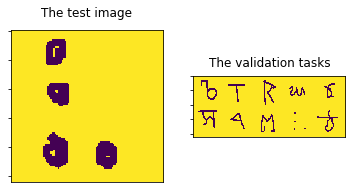

In [17]:
###Purpose of this figure is to show the accuracy of the training model
### In this block of code we are showing the test image letter and comparing it against 10 other letters. 
###One letters in the validation tasks are the same test image
pairs, target = make_one_shot(X,10)
index_target = np.argmax(target)
print("The target letter is stored in {0} index".format(index_target))
probs = model.predict(pairs)
index_prediction = np.argmax(probs)
print("The predicted match letter is stored in {0} index".format(index_prediction))
    
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
ax1.matshow(pairs[0][0].reshape(105,105))
ax1.set_title("The test image")
ax1.set_yticklabels([])
ax1.set_xticks([])
img = concat_images(pairs[1]) 
ax2.matshow(img)
ax2.set_yticklabels([])
ax2.set_xticks([])
ax2.set_title("The validation tasks")


### In this example the model was not able to identify the target letter. The corresponding test image is stored in the 
#8th index(2nd row 4th column) and the model choose the 0th index (1st row, 1st column)

In [38]:
ways = np.arange(1,10,2)
trials = 30

In [39]:
val_accs, train_accs, = [], []

In [41]:
print("Begin the evaluation stage of the training and testing data")
###testing data comes from the evaluation folder
for N in ways:
    print("Testing data accuracy on testing data\n")
    print("\n------------\n")
    val_accs.append(test_oneshot(model, N, trials, Xval, verbose=True))
    print("Testing data accuracy on Training data\n")
    print("\n------------\n")
    train_accs.append(test_oneshot(model, N, trials, X, verbose=True))
### Again the accuracy is lower since we have not extensively trained the model

Begin the evaluation stage of the training and testing data
Testing data accuracy on training data/n

------------

Evaluating model on 30 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Testing data accuracy on Evaluation data


------------

Evaluating model on 30 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Testing data accuracy on training data/n

------------

Evaluating model on 30 random 3 way one-shot learning tasks ... 

Got an average of 56.666666666666664% 3 way one-shot learning accuracy 

Testing data accuracy on Evaluation data


------------

Evaluating model on 30 random 3 way one-shot learning tasks ... 

Got an average of 56.666666666666664% 3 way one-shot learning accuracy 

Testing data accuracy on training data/n

------------

Evaluating model on 30 random 5 way one-shot learning tasks ... 

Got an average of 46.666666666666664% 5 way one-shot learning 

# Testing the data on the One-shot classification using a Meta Learning approach

In [43]:
### The model will be tested against letters that the model has never encounctered. 
### We will be using a one-shot approach in which the model will have to predict whether two images are similar or different. 
nrun = 20 # number of classification runs
fname_label = 'class_labels.txt' # where class labels are stored for each run

path = "D:\\Users\\npjos\\Documents\\Code\\Python\\all_runs\\" # loading the path file

# Modifying the Demo file: 
https://github.com/brendenlake/omniglot/blob/master/python/one-shot-classification/demo_classification.py

In [44]:

### The classification_run function loads the data using LoadImage and runs the model using the model.predict and 
### calculates the error. I  modified this function slightly to keep the np.shape to (1,105,105,1). This shape is required
### for the model to run efficiently
def classification_run(folder,f_load,f_cost,ftype='cost'):
	# Compute error rate for one run of one-shot classification
	#
	# Input
	#  folder : contains images for a run of one-shot classification
	#  f_load : itemA = f_load('file.png') should read in the image file and process it
	#  f_cost : f_cost(pair of images) should compute similarity between two images using the simaese model earlier
	#  ftype  : 'cost' if small values from f_cost mean more similar, or 'score' if large values are more similar
	#
	# Output
	#  perror : percent errors (0 to 100% error)
	# 
    assert ((ftype=='cost') | (ftype=='score'))

	# get file names
    
    with open(path+folder+'/'+fname_label) as f:
        
        content = f.read().splitlines()
    pairs = [line.split() for line in content]
    test_files  = [pair[0] for pair in pairs]
    train_files = [pair[1] for pair in pairs]
    answers_files = copy.copy(train_files)
    test_files.sort()
    train_files.sort()	
    ntrain = len(train_files)
    ntest = len(test_files)

	# load the images (and, if needed, extract features)
    train_items = [f_load(path+f) for f in train_files]
    test_items  = [f_load(path+f) for f in test_files ]

	# compute cost matrix
    costM = np.zeros((ntest,ntrain),float)
    for i in range(ntest):
        for c in range(ntrain):
            pair = [test_items[i],train_items[c]] # creating a pair so that it can used by the model
            costM[i,c] = f_cost(pair)
    if ftype == 'cost':
        YHAT = np.argmin(costM,axis=1)
    elif ftype == 'score':
        YHAT = np.argmax(costM,axis=1)
    else:
        assert False

	# compute the error rate
    correct = 0.0
    for i in range(ntest):
        if train_files[YHAT[i]] == answers_files[i]:
            correct += 1.0
    pcorrect = 100 * correct / ntest
    perror = 100 - pcorrect
    return perror

In [45]:
 ### modified the image to take the shape of model of (1,105,105,1)
def LoadImgAsPoints(fn):
   
    Image = io.imread(fn)
    Image = np.stack(Image)
    Image = np.reshape( Image, (1 , 105, 105,1))
    return Image
        


In [46]:
import copy
###Each run has 20 images and since this model is not tuned properly it has a high error rate of (98.5) 
### 
###In the demo the ModHausdorffDistance was used and that received an error rate of 38.8%. 
###Which would make that model more accepatable
##
print ('One-shot classification demo with the simaese Model')
perror = np.zeros(nrun)   
for r in range(1,nrun+1):
    rs = str(r)
    if len(rs)==1:
        rs = '0' + rs		
    perror[r-1] = classification_run('run'+rs, LoadImgAsPoints, model.predict, 'score')
    print (" run " + str(r) + " (error " + str(	perror[r-1] ) + "%)")	
#        
total = np.mean(perror)
print ( " average error " + str(total) + "%")

One-shot classification demo with the simaese Model
 run 1 (error 100.0%)
 run 2 (error 95.0%)
 run 3 (error 95.0%)
 run 4 (error 95.0%)
 run 5 (error 100.0%)
 run 6 (error 95.0%)
 run 7 (error 100.0%)
 run 8 (error 100.0%)
 run 9 (error 95.0%)
 run 10 (error 100.0%)
 run 11 (error 100.0%)
 run 12 (error 100.0%)
 run 13 (error 100.0%)
 run 14 (error 100.0%)
 run 15 (error 95.0%)
 run 16 (error 100.0%)
 run 17 (error 100.0%)
 run 18 (error 100.0%)
 run 19 (error 100.0%)
 run 20 (error 100.0%)
 average error 98.5%


In [60]:
###Function to plot images from the One shot classification folder
def plot_img(pair,cost):

    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pair[0].reshape(105,105))
    ax1.set_title("The test image")
    ax1.set_yticklabels([])
    ax1.set_xticks([]) 
    ax1.set_yticklabels([])
        
    ax2.matshow(pair[1].reshape(105,105))
    ax2.set_yticklabels([])
    ax2.set_title("The validation tasks")
    ax2.set_xticks([])
    print("The similarity between the two is: {0}".format(cost))
    

In [80]:
### Modified version of classification function to include plotting function
def classification_run_image(folder,f_load,f_cost,ftype='cost', Image = False):
	# Compute error rate for one run of one-shot classification
	#
	# Input
	#  folder : contains images for a run of one-shot classification
	#  f_load : itemA = f_load('file.png') should read in the image file and process it
	#  f_cost : f_cost(itemA,itemB) should compute similarity between two images, using output of f_load
	#  ftype  : 'cost' if small values from f_cost mean more similar, or 'score' if large values are more similar
	#
	# Output
	#  perror : percent errors (0 to 100% error)
	# 
    assert ((ftype=='cost') | (ftype=='score'))

	# get file names
    
    with open(path+folder+'/'+fname_label) as f:
        #print(f)
        content = f.read().splitlines()
        #content = path+'/'+content
        #print(f)
    #print(content)
    pairs = [line.split() for line in content]
    test_files  = [pair[0] for pair in pairs]
    train_files = [pair[1] for pair in pairs]
    answers_files = copy.copy(train_files)
    test_files.sort()
    train_files.sort()	
    ntrain = len(train_files)
    ntest = len(test_files)
    #print(path+'/'+content)
	# load the images (and, if needed, extract features)
    train_items = [f_load(path+'/'+f) for f in train_files]
    test_items  = [f_load(path+'/'+f) for f in test_files ]

	# compute cost matrix
    costM = np.zeros((ntest,ntrain),float)
    for i in range(ntest):
        for c in range(ntrain):
            pair = [test_items[i],train_items[c]] # creating a pair so that it can used by the model
            costM[i,c] = f_cost(pair)               
            if (Image == True and i == 4 and c == 7):
               plot_img(pair,costM[i,c])
            
    if ftype == 'cost':
        YHAT = np.argmin(costM,axis=1)
    elif ftype == 'score':
        YHAT = np.argmax(costM,axis=1)
    else:
        assert False

	# compute the error rate
    correct = 0.0
    for i in range(ntest):
        if train_files[YHAT[i]] == answers_files[i]:
            correct += 1.0
    pcorrect = 100 * correct / ntest
    perror = 100 - pcorrect
    return perror

The similarity between the two is: 0.9791455268859863
run01/training/class18.png run01/training/class18.png [11  4  3  9 11 17 17  9 14  8  4 19  9  3 15  4 11  4 14 15] 17
run01/training/class05.png run01/training/class05.png [11  4  3  9 11 17 17  9 14  8  4 19  9  3 15  4 11  4 14 15] 4
run01/training/class16.png run01/training/class16.png [11  4  3  9 11 17 17  9 14  8  4 19  9  3 15  4 11  4 14 15] 15
85.0


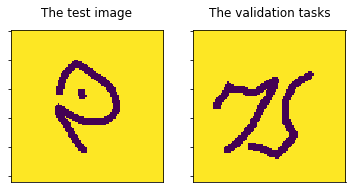

In [82]:
### We can see that the test image and the validation tasks are different(visually), however the similarity score is high. 
### This might be due to lack of training iteration.
error = classification_run_image('run'+'01', LoadImgAsPoints, model.predict, 'score',True)
print(error)

# It seems that hyperparameter tuning needs to be conducted on the Siamese  Network  inorder to improve the accuracy of the model. More specifically, the model needs to be trained for more iterations to improve accuracy. 